## 1. 환경 설정

`(1) Env 환경변수`

In [1]:
from dotenv import load_dotenv
load_dotenv()

True

In [10]:

import warnings
warnings.filterwarnings("ignore")

`(2) 기본 라이브러리`

In [2]:
import re
import os, json
from glob import glob

from textwrap import dedent
from pprint import pprint

import uuid

import warnings
warnings.filterwarnings("ignore")

## 2. 법률 문서를 로드하여 벡터저장소에 저장

In [3]:
# pdf 파일 목록을 확인
pdf_files = glob(os.path.join('data', '*.pdf'))

pdf_files

['data\\개인정보 보호법(법률)(제19234호)(20240315).pdf',
 'data\\근로기준법(법률)(제18176호)(20211119).pdf',
 'data\\주택임대차보호법(법률)(제19356호)(20230719).pdf']

###  2-1. 개인정보보호법

- PDf 문서를 가져와서 조항 별로 구분하여 정리

In [4]:
from langchain_community.document_loaders import PyPDFLoader
pdf_file=pdf_files[0]
# pdf_file = 'data/개인정보 보호법(법률)(제19234호)(20240315).pdf'

loader = PyPDFLoader(pdf_file)
pages = loader.load()

len(pages)

41

In [ ]:
pages[0].page_content

In [ ]:
pages[0].metadata

In [ ]:
print(pages[0].page_content)

In [5]:
def parse_law(law_text):
    # 서문 분리
    # '^'로 시작하여 '제1장' 또는 '제1조' 직전까지의 모든 텍스트를 탐색 
    preamble_pattern = r'^(.*?)(?=제1장|제1조)'
    preamble = re.search(preamble_pattern, law_text, re.DOTALL)
    if preamble:
        preamble = preamble.group(1).strip()
    
    # 장 분리 
    # '제X장' 형식의 제목과 그 뒤에 오는 모든 조항을 하나의 그룹화 
    chapter_pattern = r'(제\d+장\s+.+?)\n((?:제\d+조(?:의\d+)?(?:\(\w+\))?.*?)(?=제\d+장|부칙|$))'
    chapters = re.findall(chapter_pattern, law_text, re.DOTALL)
    
    # 부칙 분리
    # '부칙'으로 시작하는 모든 텍스트를 탐색 
    appendix_pattern = r'(부칙.*)'
    appendix = re.search(appendix_pattern, law_text, re.DOTALL)
    if appendix:
        appendix = appendix.group(1)
    
    # 파싱 결과를 저장할 딕셔너리 초기화
    parsed_law = {'서문': preamble, '장': {}, '부칙': appendix}
    
    # 각 장 내에서 조 분리
    for chapter_title, chapter_content in chapters:
        # 조 분리 패턴
        # 1. '제X조'로 시작 ('제X조의Y' 형식도 가능)
        # 2. 조 번호 뒤에 반드시 '(항목명)' 형식의 제목이 와야 함 
        # 3. 다음 조가 시작되기 전까지 또는 문서의 끝까지의 모든 내용을 포함
        article_pattern = r'(제\d+조(?:의\d+)?\s*\([^)]+\).*?)(?=제\d+조(?:의\d+)?\s*\([^)]+\)|$)'
        
        # 정규표현식을 이용해 모든 조항을 탐색 
        articles = re.findall(article_pattern, chapter_content, re.DOTALL)
        
        # 각 조항의 앞뒤 공백을 제거하고 결과 딕셔너리에 저장
        parsed_law['장'][chapter_title.strip()] = [article.strip() for article in articles]
    
    return parsed_law


# 각 페이지의 텍스트를 결합하여 재분리
text_for_delete = r"법제처\s+\d+\s+국가법령정보센터\n개인정보 보호법"

law_text = "\n".join([re.sub(text_for_delete, "", p.page_content).strip() for p in pages])

parsed_law = parse_law(law_text)

# 분할된 아이템 갯수 확인
print(len(parsed_law["장"]))

10


In [ ]:
parsed_law

- 랭체인 Document 객체에 메타데이터와 함께 정리

In [6]:
from langchain_core.documents import Document

final_docs = []
for law in parsed_law['장'].keys():
    for article in parsed_law['장'][law]:

        # metadata 내용을 정리 
        metadata = {
                "source": pdf_file,
                "chapter": law,
                "name" : "개인정보 보호법"
                }

        # metadata 내용을 본문에 추가 
        content = f"[법률정보]\n다음 조항은 {metadata['name']} {metadata['chapter']}에서 발췌한 내용입니다.\n\n[법률조항]\n{article}"

        final_docs.append(Document(page_content=content, metadata=metadata))
        
len(final_docs)


109

In [7]:
print(final_docs[0].page_content)
print()
print(final_docs[0].metadata)
print(final_docs[1].page_content)
print()
print(final_docs[1].metadata)

[법률정보]
다음 조항은 개인정보 보호법 제1장 총칙에서 발췌한 내용입니다.

[법률조항]
제1조(목적) 이 법은 개인정보의 처리 및 보호에 관한 사항을 정함으로써 개인의 자유와 권리를 보호하고, 나아가 개인
의 존엄과 가치를 구현함을 목적으로 한다. <개정 2014. 3. 24.>

{'source': 'data\\개인정보 보호법(법률)(제19234호)(20240315).pdf', 'chapter': '제1장 총칙', 'name': '개인정보 보호법'}
[법률정보]
다음 조항은 개인정보 보호법 제1장 총칙에서 발췌한 내용입니다.

[법률조항]
제2조(정의) 이 법에서 사용하는 용어의 뜻은 다음과 같다. <개정 2014. 3. 24., 2020. 2. 4., 2023. 3. 14.>
1. “개인정보”란 살아 있는 개인에 관한 정보로서 다음 각 목의 어느 하나에 해당하는 정보를 말한다.
가. 성명, 주민등록번호 및 영상 등을 통하여 개인을 알아볼 수 있는 정보 
나. 해당 정보만으로는 특정 개인을 알아볼 수 없더라도 다른 정보와 쉽게 결합하여 알아볼 수 있는 정보. 이 경우 
쉽게 결합할 수 있는지 여부는 다른 정보의 입수 가능성 등 개인을 알아보는 데 소요되는 시간, 비용, 기술 등 
을 합리적으로 고려하여야 한다. 
다. 가목 또는 나목을 제1호의2에 따라 가명처리함으로써 원래의 상태로 복원하기 위한 추가 정보의 사용ㆍ결합 
없이는 특정 개인을 알아볼 수 없는 정보(이하 “가명정보”라 한다) 
1의2. “가명처리”란 개인정보의 일부를 삭제하거나 일부 또는 전부를 대체하는 등의 방법으로 추가 정보가 없이는
특정 개인을 알아볼 수 없도록 처리하는 것을 말한다. 
2. “처리”란 개인정보의 수집, 생성, 연계, 연동, 기록, 저장, 보유, 가공, 편집, 검색, 출력, 정정(訂正), 복구, 이용, 제공,
공개, 파기(破棄), 그 밖에 이와 유사한 행위를 말한다. 
3. “정보주체”란 처리되는 정보에 의하여 알아볼 수 있는 사람으로서 그 정보의 주체가 되는 사람을 말

In [ ]:
print(final_docs[-1].page_content)
print()
print(final_docs[-1].metadata)

- 벡터저장소에 인덱싱

In [8]:
# 각 문서의 텍스트 길이를 확인

text_lengths = [len(d.page_content) for d in final_docs]
print(min(text_lengths), max(text_lengths))

116 2844


In [11]:
from langchain_chroma import Chroma
from langchain_ollama  import OllamaEmbeddings

embeddings_model = OllamaEmbeddings(model="bge-m3") 

# Chroma 인덱스 생성
personal_db = Chroma.from_documents(
    documents=final_docs, 
    embedding=embeddings_model,   
    collection_name="personal_law",
    persist_directory="./chroma_db",
)

Failed to send telemetry event ClientStartEvent: capture() takes 1 positional argument but 3 were given
Failed to send telemetry event ClientCreateCollectionEvent: capture() takes 1 positional argument but 3 were given


###  2-2. 근로기준법

- PDf 문서를 가져와서 조항 별로 구분하여 정리

In [12]:
from langchain_community.document_loaders import PyPDFLoader
pdf_file=pdf_files[1]
# pdf_file = 'data/근로기준법(법률)(제18176호)(20211119).pdf'

loader = PyPDFLoader(pdf_file)
pages = loader.load()

len(pages)

20

In [13]:
pages[0].page_content

'법제처                                                            1                                                       국가법령정보센터\n근로기준법 \n \n근로기준법 \n[시행 2021. 11. 19.] [법률 제18176호, 2021. 5. 18., 일부개정] \n고용노동부 (근로기준정책과 - 해고, 취업규칙, 기타) 044-202-7534 \n고용노동부 (근로기준정책과 - 소년) 044-202-7535 \n고용노동부 (근로기준정책과 - 임금) 044-202-7548 \n고용노동부 (여성고용정책과 - 여성) 044-202-7475 \n고용노동부 (임금근로시간정책과 - 근로시간, 휴게) 044-202-7545 \n고용노동부 (임금근로시간정책과 - 휴일, 연차휴가) 044-202-7973 \n고용노동부 (임금근로시간정책과 - 제63조 적용제외, 특례업종) 044-202-7530 \n고용노동부 (임금근로시간정책과 - 유연근로시간제) 044-202-7549 \n       제1장 총칙\n \n제1조(목적) 이 법은 헌법에 따라 근로조건의 기준을 정함으로써 근로자의 기본적 생활을 보장, 향상시키며 균형 있는\n국민경제의 발전을 꾀하는 것을 목적으로 한다.\n \n제2조(정의) ① 이 법에서 사용하는 용어의 뜻은 다음과 같다. <개정 2018. 3. 20., 2019. 1. 15., 2020. 5. 26.>\n1. “근로자”란 직업의 종류와 관계없이 임금을 목적으로 사업이나 사업장에 근로를 제공하는 사람을 말한다.\n2. “사용자”란 사업주 또는 사업 경영 담당자, 그 밖에 근로자에 관한 사항에 대하여 사업주를 위하여 행위하는 자를\n말한다. \n3. “근로”란 정신노동과 육체노동을 말한다.\n4. “근로계약”이란 근로자가 사용자에게 근로를 제공하고 사용자는 이에 대하여 임금을 지급하는 것을 목적으로 체\n결된 계약을 말한다. \n5. “임금”이란 사용자가 근로의 대가로 근

In [ ]:
# 각 페이지의 텍스트를 결합하여 재분리
text_for_delete = r"법제처\s+\d+\s+국가법령정보센터\n근로기준법"

law_text = "\n".join([re.sub(text_for_delete, "", p.page_content).strip() for p in pages])

parsed_law = parse_law(law_text)

# 분할된 아이템 갯수 확인
print(len(parsed_law["장"]))

In [ ]:
parsed_law

- 랭체인 Document 객체에 메타데이터와 함께 정리

In [14]:
from langchain_core.documents import Document

final_docs = []
for law in parsed_law['장'].keys():
    for article in parsed_law['장'][law]:

        # metadata 내용을 정리 
        metadata = {
                "source": pdf_file,
                "chapter": law,
                "name" : "근로기준법"
                }

        # metadata 내용을 본문에 추가 
        content = f"[법률정보]\n다음 조항은 {metadata['name']} {metadata['chapter']}에서 발췌한 내용입니다.\n\n[법률조항]\n{article}"

        final_docs.append(Document(page_content=content, metadata=metadata))
        
len(final_docs)

109

In [15]:
print(final_docs[0].page_content)
print()
print(final_docs[0].metadata)

[법률정보]
다음 조항은 근로기준법 제1장 총칙에서 발췌한 내용입니다.

[법률조항]
제1조(목적) 이 법은 개인정보의 처리 및 보호에 관한 사항을 정함으로써 개인의 자유와 권리를 보호하고, 나아가 개인
의 존엄과 가치를 구현함을 목적으로 한다. <개정 2014. 3. 24.>

{'source': 'data\\근로기준법(법률)(제18176호)(20211119).pdf', 'chapter': '제1장 총칙', 'name': '근로기준법'}


In [ ]:
print(final_docs[-1].page_content)
print()
print(final_docs[-1].metadata)

- 벡터저장소에 인덱싱

In [16]:
# 각 문서의 텍스트 길이를 확인

text_lengths = [len(d.page_content) for d in final_docs]
print(min(text_lengths), max(text_lengths))

121 2849


In [17]:
from langchain_chroma import Chroma
from langchain_ollama  import OllamaEmbeddings

embeddings_model = OllamaEmbeddings(model="bge-m3") 

# Chroma 인덱스 생성
labor_db = Chroma.from_documents(
    documents=final_docs, 
    embedding=embeddings_model,   
    collection_name="labor_law",
    persist_directory="./chroma_db",
)

Failed to send telemetry event ClientStartEvent: capture() takes 1 positional argument but 3 were given
Failed to send telemetry event ClientCreateCollectionEvent: capture() takes 1 positional argument but 3 were given


###  2-3. 주택임대차보호법

- PDf 문서를 가져와서 조항 별로 구분하여 정리

In [18]:
from langchain_community.document_loaders import PyPDFLoader
pdf_file = pdf_files[2]
# pdf_file = 'data/주택임대차보호법(법률)(제19356호)(20230719).pdf'

loader = PyPDFLoader(pdf_file)
pages = loader.load()

len(pages)

10

In [21]:
# 파싱 함수를 수정 (장이 없이 조문으로만 구성된 경우)
def parse_law_v2(law_text):
    # 서문 분리
    preamble_pattern = r'^(.*?)(?=제1장|제1조)'
    preamble = re.search(preamble_pattern, law_text, re.DOTALL)
    if preamble:
        preamble = preamble.group(1).strip()
    
    # 장 분리 
    chapter_pattern = r'(제\d+장\s+.+?)\n((?:제\d+조(?:의\d+)?(?:\(\w+\))?.*?)(?=제\d+장|부칙|$))'
    chapters = re.findall(chapter_pattern, law_text, re.DOTALL)
    
    # 부칙 분리
    appendix_pattern = r'(부칙.*)'
    appendix = re.search(appendix_pattern, law_text, re.DOTALL)
    if appendix:
        appendix = appendix.group(1)
    
    parsed_law = {'서문': preamble, '부칙': appendix}
    
    # 조 분리 패턴
    article_pattern = r'(제\d+조(?:의\d+)?\s*\([^)]+\).*?)(?=제\d+조(?:의\d+)?\s*\([^)]+\)|$)'
    
    if chapters:  # 장이 있는 경우
        parsed_law['장'] = {}
        for chapter_title, chapter_content in chapters:
            articles = re.findall(article_pattern, chapter_content, re.DOTALL)
            parsed_law['장'][chapter_title.strip()] = [article.strip() for article in articles]
    else:  # 장이 없는 경우
        # 서문과 부칙을 제외한 본문에서 조문 추출
        main_text = re.sub(preamble_pattern, '', law_text, flags=re.DOTALL)
        main_text = re.sub(appendix_pattern, '', main_text, flags=re.DOTALL)
        articles = re.findall(article_pattern, main_text, re.DOTALL)
        parsed_law['조문'] = [article.strip() for article in articles]
    
    return parsed_law

In [22]:
# 각 페이지의 텍스트를 결합하여 재분리
text_for_delete = r"법제처\s+\d+\s+국가법령정보센터\n주택임대차보호법"

law_text = "\n".join([re.sub(text_for_delete, "", p.page_content).strip() for p in pages])

parsed_law = parse_law_v2(law_text)

# 분할된 아이템 갯수 확인
print(len(parsed_law["조문"]))

41


In [ ]:
parsed_law

- 랭체인 Document 객체에 메타데이터와 함께 정리

In [23]:
from langchain_core.documents import Document

final_docs = []
for article in parsed_law['조문']:

    # metadata 내용을 정리 
    metadata = {
            "source": pdf_file,
            "name" : "주택임대차보호법"
            }

    # metadata 내용을 본문에 추가 
    content = f"[법률정보]\n다음 조항은 {metadata['name']}에서 발췌한 내용입니다.\n\n[법률조항]\n{article}"

    final_docs.append(Document(page_content=content, metadata=metadata))

        
len(final_docs)

41

In [ ]:
print(final_docs[0].page_content)
print()
print(final_docs[0].metadata)

In [ ]:
print(final_docs[-1].page_content)
print()
print(final_docs[-1].metadata)

- 벡터저장소에 인덱싱

In [24]:
# 각 문서의 텍스트 길이를 확인

text_lengths = [len(d.page_content) for d in final_docs]
print(min(text_lengths), max(text_lengths))

123 1879


In [25]:
from langchain_chroma import Chroma
from langchain_ollama  import OllamaEmbeddings

embeddings_model = OllamaEmbeddings(model="bge-m3") 

# Chroma 인덱스 생성
housing_db = Chroma.from_documents(
    documents=final_docs, 
    embedding=embeddings_model,   
    collection_name="housing_law",
    persist_directory="./chroma_db",
)

Failed to send telemetry event ClientStartEvent: capture() takes 1 positional argument but 3 were given
Failed to send telemetry event ClientCreateCollectionEvent: capture() takes 1 positional argument but 3 were given


## Vector DB 로딩


In [26]:
from langchain_chroma import Chroma
from langchain_ollama  import OllamaEmbeddings
embeddings_model = OllamaEmbeddings(model="bge-m3") 
# personal_db 검색 
personal_db = Chroma(
    embedding_function=embeddings_model,   
    collection_name="personal_law",
    persist_directory="./chroma_db",
)
# labor_db 검색 
labor_db = Chroma(
    embedding_function=embeddings_model,   
    collection_name="labor_law",
    persist_directory="./chroma_db",
)
# labor_db 검색 
housing_db = Chroma(
    embedding_function=embeddings_model,   
    collection_name="housing_law",
    persist_directory="./chroma_db",
)

Failed to send telemetry event ClientStartEvent: capture() takes 1 positional argument but 3 were given
Failed to send telemetry event ClientCreateCollectionEvent: capture() takes 1 positional argument but 3 were given
Failed to send telemetry event ClientStartEvent: capture() takes 1 positional argument but 3 were given
Failed to send telemetry event ClientCreateCollectionEvent: capture() takes 1 positional argument but 3 were given
Failed to send telemetry event ClientStartEvent: capture() takes 1 positional argument but 3 were given
Failed to send telemetry event ClientCreateCollectionEvent: capture() takes 1 positional argument but 3 were given


# 3. 도구 호출

### 3-1. 법률 정보 검색 도구, 웹 검색 도구 정의

In [27]:
from langchain_chroma import Chroma
from langchain_ollama  import OllamaEmbeddings
from langchain_core.documents import Document

from langchain.retrievers import ContextualCompressionRetriever
from langchain.retrievers.document_compressors import CrossEncoderReranker
from langchain_community.cross_encoders import HuggingFaceCrossEncoder
from langchain_community.retrievers import TavilySearchAPIRetriever
from langchain_core.tools import tool
from typing import List

# 문서 임베딩 모델
embeddings_model = OllamaEmbeddings(model="bge-m3") 

# Re-rank 모델
rerank_model = HuggingFaceCrossEncoder(model_name="BAAI/bge-reranker-v2-m3")
cross_reranker = CrossEncoderReranker(model=rerank_model, top_n=2)

# # 개인정보보호법 검색 
personal_db = Chroma(
    embedding_function=embeddings_model,   
    collection_name="personal_law",
    persist_directory="./chroma_db",
)

personal_db_retriever = ContextualCompressionRetriever(
    base_compressor=cross_reranker, 
    base_retriever=personal_db.as_retriever(search_kwargs={"k":2}),
)

@tool
def personal_law_search(query: str) -> List[Document]:
    """개인정보보호법 법률 조항을 검색합니다."""
    docs = personal_db_retriever.invoke(query)

    if len(docs) > 0:
        return docs
    
    return [Document(page_content="관련 정보를 찾을 수 없습니다.")]


# 근로기준법 검색 
labor_db = Chroma(
    embedding_function=embeddings_model,   
    collection_name="labor_law",
    persist_directory="./chroma_db",
)

labor_db_retriever = ContextualCompressionRetriever(
    base_compressor=cross_reranker, 
    base_retriever=labor_db.as_retriever(search_kwargs={"k":2}),
)


@tool
def labor_law_search(query: str) -> List[Document]:
    """근로기준법 법률 조항을 검색합니다."""
    docs = labor_db_retriever.invoke(query)

    if len(docs) > 0:
        return docs
    
    return [Document(page_content="관련 정보를 찾을 수 없습니다.")]


# 주택임대차보호법 검색 
housing_db = Chroma(
    embedding_function=embeddings_model,   
    collection_name="housing_law",
    persist_directory="./chroma_db",
)

housing_db_retriever = ContextualCompressionRetriever(
    base_compressor=cross_reranker, 
    base_retriever=housing_db.as_retriever(search_kwargs={"k":2}),
)



@tool
def housing_law_search(query: str) -> List[Document]:
    """주택임대차보호법 법률 조항을 검색합니다."""
    docs = housing_db_retriever.invoke(query)

    if len(docs) > 0:
        return docs
    
    return [Document(page_content="관련 정보를 찾을 수 없습니다.")]



# 웹 검색
web_retriever = ContextualCompressionRetriever(
    base_compressor=cross_reranker, 
    base_retriever=TavilySearchAPIRetriever(k=10),
)

@tool
def web_search(query: str) -> List[str]:
    """데이터베이스에 없는 정보 또는 최신 정보를 웹에서 검색합니다."""

    docs = web_retriever.invoke(query)

    formatted_docs = []
    for doc in docs:
        formatted_docs.append(
            Document(
                page_content= f'<Document href="{doc.metadata["source"]}"/>\n{doc.page_content}\n</Document>',
                metadata={"source": "web search", "url": doc.metadata["source"]}
            )
        )

    if len(formatted_docs) > 0:
        return formatted_docs
    
    return [Document(page_content="관련 정보를 찾을 수 없습니다.")]

Failed to send telemetry event ClientStartEvent: capture() takes 1 positional argument but 3 were given
Failed to send telemetry event ClientCreateCollectionEvent: capture() takes 1 positional argument but 3 were given
Failed to send telemetry event ClientStartEvent: capture() takes 1 positional argument but 3 were given
Failed to send telemetry event ClientCreateCollectionEvent: capture() takes 1 positional argument but 3 were given
Failed to send telemetry event ClientStartEvent: capture() takes 1 positional argument but 3 were given
Failed to send telemetry event ClientCreateCollectionEvent: capture() takes 1 positional argument but 3 were given


In [28]:
# 도구 목록을 정의 
tools = [personal_law_search, labor_law_search, housing_law_search, web_search]

### 3-2. LLM 모델

In [29]:
from langchain_openai import ChatOpenAI
# # 기본 LLM
# llm = ChatOpenAI(model="gpt-4o-mini", temperature=0, streaming=True)

import os

os.environ["OPENAI_API_VERSION"] = os.getenv('AZURE_OPENAI_VERSION')
os.environ["AZURE_OPENAI_ENDPOINT"] = os.getenv('AZURE_OPENAI_END_POINT')
os.environ["AZURE_OPENAI_API_KEY"] = os.getenv('AZURE_OPENAI_KEY')

from langchain_openai import AzureChatOpenAI

llm = AzureChatOpenAI(
    azure_deployment=os.getenv('DEPLOYMENT_NAME'),  # or your deployment
    api_version=os.getenv('AZURE_OPENAI_VERSION'),  # or your api version
    temperature=0,
    # stream=True,
    # max_tokens=40000,
    # timeout=None,
    # max_retries=2,
    # other params...
)

# from langchain_anthropic import ChatAnthropic
# 
# # claude 모델 로드 
# llm = ChatAnthropic(
#     # model="claude-3-5-sonnet-20241022",
#     model="claude-3-7-sonnet-20250219",
#     temperature=0,
#     # max_tokens=200, 
#     api_key=os.getenv('ANTHROPIC_API_KEY'),
#     streaming=True,
# )


# LLM에 도구 바인딩하여 추가 
llm_with_tools = llm.bind_tools(tools)

In [30]:
# 근로기준법과 관련된 질문을 하는 경우 -> 근로기준법 검색 도구를 호출  
query = "연차휴가 부여 기준에 대해서 설명해주세요."
ai_msg = llm_with_tools.invoke(query)

# pprint(ai_msg)
# print("-" * 100)
# 
# pprint(ai_msg.content)
# print("-" * 100)
# 
# pprint(ai_msg.tool_calls)
# print("-" * 100)

In [31]:
pprint(ai_msg)
print("-" * 100)

pprint(ai_msg.content)
print("-" * 100)

pprint(ai_msg.tool_calls)
print("-" * 100)

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_jz74fRWntIpy8OihGIXo32tm', 'function': {'arguments': '{"query":"연차휴가 부여 기준"}', 'name': 'labor_law_search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 24, 'prompt_tokens': 152, 'total_tokens': 176, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_ee1d74bde0', 'id': 'chatcmpl-Bo1gEDjMS6jlCFDcKvS269YG6Ynve', 'service_tier': None, 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}}], 'finish_reason': 'tool_calls', 'logprobs': None

In [ ]:
# 도구들의 목적과 관련 없는 질문을 하는 경우 -> 도구 호출 없이 그대로 답변을 생성 
query = "안녕하세요?"
ai_msg = llm_with_tools.invoke(query)

pprint(ai_msg)
print("-" * 100)

pprint(ai_msg.content)
print("-" * 100)

pprint(ai_msg.tool_calls)
print("-" * 100)

In [ ]:
# 벡터 검색과 웹 검색이 모두 필요한 경우 
query = "연차휴가 부여 기준에 대해서 설명해주세요. 2023년 연차휴가 사용 비율은 어느 정도인가요?"
ai_msg = llm_with_tools.invoke(query)

pprint(ai_msg)
print("-" * 100)

pprint(ai_msg.content)
print("-" * 100)

pprint(ai_msg.tool_calls)
print("-" * 100)

In [ ]:
# 벡터 검색과 웹 검색이 모두 필요한 경우 
query = "전월세 직거래 시에 유의사항은 무엇인가요?"
ai_msg = llm_with_tools.invoke(query)

pprint(ai_msg)
print("-" * 100)

pprint(ai_msg.content)
print("-" * 100)

pprint(ai_msg.tool_calls)
print("-" * 100)

# 4. Agent RAG 구현 

- 각 법률에 특화된 RAG 에이전트를 구현 
- 질문 라우팅을 통해서 각 에이전트를 도구 형태로 사용 
- 생성된 답변에 대한 피드백을 제공하는 에이전트 사용 
- 필요한 경우 사람의 피드백을 요청 (답변이 애매한 경우 - 재검색 여부 판단)


### 4-1. 각 법률에 특화된 RAG 에이전트를 구현 
- 검색된 문서의 관련성 등을 평가하여 질문 재작성 및 다시 검색 (Corrective RAG 적용)

`(1) 개인정보보호법 검색 에이전트`

In [32]:
from pydantic import BaseModel, Field
from typing import List, TypedDict, Annotated, Optional
from operator import add
from langchain_core.documents import Document

#  Corrective RAG 상태 관리 클래스
class CorrectiveRagState(TypedDict):
    question: str                 # 사용자의 질문
    generation: str               # LLM 생성 답변
    documents: List[Document]     # 컨텍스트 문서 (검색된 문서)
    num_generations: int          # 질문 or 답변 생성 횟수 (무한 루프 방지에 활용)

# 추출된 정보 조각과 평가 (관련성 및 충실성) 점수 관리 클래스
class InformationStrip(BaseModel):
    """추출된 정보에 대한 내용과 출처, 관련성 점수"""
    content: str = Field(..., description="추출된 정보 내용")
    source: str = Field(..., description="정보의 출처(법률 조항 또는 URL 등). 예시: 환경법 제22조 3항 or 블로그 환경법 개정 (https://blog.com/page/123)")
    relevance_score: float = Field(..., ge=0, le=1, description="추출된 정보 단위의 관련성 점수 (0에서 1 사이)")
    faithfulness_score: float = Field(..., ge=0, le=1, description="추출된 정보 단위의 충실성 점수 (0에서 1 사이)")

# 추출된 정보 조각 들의 리스트 와 종합 점수 관리 클래스
class ExtractedInformation(BaseModel):
    strips: List[InformationStrip] = Field(..., description="추출된 정보 조각 리스트 [InformationStrip]")
    query_relevance: float = Field(..., ge=0, le=1, description="질의에 대한 종합 답변 가능성 점수 (0에서 1 사이)")

# 개선 질문 및 이유 관리 클래스
class RefinedQuestion(BaseModel):
    """ llm이 개선한 질문과 이유"""
    question_refined : str = Field(..., description="개선된 질문")
    reason : str = Field(..., description="이유")

# 개인정보보호법 검색 에이전드 상태 관리 클래스
# CRAG 상태 관리 클래스 상속
class PersonalRagState(CorrectiveRagState):
    rewritten_query: str   # 재 작성한 질문 
    extracted_info: Optional[ExtractedInformation]   # 추출된 정보 조각 
    node_answer: Optional[str]

In [33]:
from langchain_core.prompts import ChatPromptTemplate
from typing import Literal
# 노드 정의

# 문서 검색 하는 노드
# in : 개인 정보 보호법 검색 AGENT 상태 관리 객체 
# out: 개인 정보 보호법 검색 AGENT 상태 관리 객체   
def retrieve_documents(state: PersonalRagState) -> PersonalRagState:
    print("---문서 검색---")
    # 재 작성한 쿼리가 없다면, 사용자 입력 쿼리
    query = state.get("rewritten_query", state["question"])
    # 개인 정보 보호법 검색 객체로 문서 검색 수행.
    docs = personal_law_search.invoke(query)
    # 개인 정보 보호법 검색 에이전드 상태 관리 객체의 documents 상태를 검색된 문서 리스트로 업데이트 함 
    return {"documents": docs}

# 추출된 정보를 평가 하는 노드
# in : 개인 정보 보호법 검색 AGENT 상태 관리 객체 
# out: 개인 정보 보호법 검색 AGENT 상태 관리 객체 
def extract_and_evaluate_information(state: PersonalRagState) -> PersonalRagState:
    print("---정보 추출 및 평가---")
    # 우수한 정보 조각 보관 리스트
    extracted_strips = []
    # 개인 정보 보호법 검색 에이전드 상태 관리 객체의 문서 정보 에서 문서를 하나씩 읽음.
    for doc in state["documents"]:
        # 문서의 정보 조각화 그리고 평가를 위한 LLM instruction
        # input: question, document_content
        # output: "추출된 정보 조각 리스트 [InformationStrip]" & "질의에 대한 종합 답변 가능성 점수 (0에서 1 사이)"
        extract_prompt = ChatPromptTemplate.from_messages([
            ("system", """당신은 개인정보보호법 전문가입니다. 주어진 문서에서 질문과 관련된 주요 사실과 정보를 3~5개 정도 추출하세요. 
            각 추출된 정보에 대해 다음 두 가지 측면을 0에서 1 사이의 점수로 평가하세요:
            1. 질문과의 관련성
            2. 답변의 충실성 (질문에 대한 완전하고 정확한 답변을 제공할 수 있는 정도)
            
            추출 형식:
            1. [추출된 정보]
            - 관련성 점수: [0-1 사이의 점수]
            - 충실성 점수: [0-1 사이의 점수]
            2. [추출된 정보]
            - 관련성 점수: [0-1 사이의 점수]
            - 충실성 점수: [0-1 사이의 점수]
            ...
            
            마지막으로, 추출된 정보를 종합하여 질문에 대한 전반적인 답변 가능성을 0에서 1 사이의 점수로 평가하세요."""),
            ("human", "[질문]\n{question}\n\n[문서 내용]\n{document_content}")
        ])
        # 체인 생성
        extract_llm = llm.with_structured_output(ExtractedInformation)
        # 체인 실행 
        extracted_data = extract_llm.invoke(extract_prompt.format(
            question=state["question"],
            document_content=doc.page_content
        ))
        # 만약, ExtractedInformation 종합 점수가 0.8 보다 낮으면 loop 계속
        if extracted_data.query_relevance < 0.8:
            continue
        # 3~5 개의 정보 조각 종합 점수가 0.8 같거나 크고, 각 정보 조각별 연관, 충실성 점수 0.7 점 보다 같거나 크면,
        # 우수한 정보 조각 리스트 보관
        for strip in extracted_data.strips:
            if strip.relevance_score > 0.7 and strip.faithfulness_score > 0.7:
                extracted_strips.append(strip)
    # 우수한 정보 조각들 & 평가 수행 횟수 UPDATE ON "개인 정보 보호법 검색 AGENT 상태 관리 객체"  
    return {
        "extracted_info": extracted_strips,
        "num_generations": state.get("num_generations", 0) + 1
    }

# 질문 개선 수행 노드
# in : 개인 정보 보호법 검색 AGENT 상태 관리 객체 
# out: 개인 정보 보호법 검색 AGENT 상태 관리 객체 
def rewrite_query(state: PersonalRagState) -> PersonalRagState:
    print("---쿼리 재작성---")
    # 원래 질문: 2-3개의 후보 쿼리와 이유를 생성 하고 가장 우수한 퀴리를 하나 선택 하는 LLM instruction
    # input: 원래 질문: {question} 우수한 정보 조각:\n{extracted_info}
    # output: 개선 질문 및 이유
    rewrite_prompt = ChatPromptTemplate.from_messages([
        ("system", """당신은 개인정보보호법 전문가입니다. 주어진 원래 질문과 추출된 정보를 바탕으로, 더 관련성 있고 충실한 정보를 찾기 위해 검색 쿼리를 개선해주세요.

        다음 사항을 고려하여 검색 쿼리를 개선하세요:
        1. 원래 질문의 핵심 요소
        2. 추출된 정보의 관련성 점수
        3. 추출된 정보의 충실성 점수
        4. 부족한 정보나 더 자세히 알아야 할 부분

        개선된 검색 쿼리 작성 단계:
        1. 2-3개의 검색 쿼리를 제안하세요.
        2. 각 쿼리는 구체적이고 간결해야 합니다(5-10 단어 사이).
        3. 개인정보보호법과 관련된 전문 용어를 적절히 활용하세요.
        4. 각 쿼리 뒤에는 해당 쿼리를 제안한 이유를 간단히 설명하세요.

        출력 형식:
        1. [개선된 검색 쿼리 1]
        - 이유: [이 쿼리를 제안한 이유 설명]
        2. [개선된 검색 쿼리 2]
        - 이유: [이 쿼리를 제안한 이유 설명]
        3. [개선된 검색 쿼리 3]
        - 이유: [이 쿼리를 제안한 이유 설명]

        마지막으로, 제안된 쿼리 중 가장 효과적일 것 같은 쿼리를 선택하고 그 이유를 설명하세요."""),
        ("human", "원래 질문: {question}\n\n추출된 정보:\n{extracted_info}\n\n위 지침에 따라 개선된 검색 쿼리를 작성해주세요.")
    ])
    # 우수한 정보 조각 리스트 문자열 변환
    extracted_info_str = "\n".join([strip.content for strip in state["extracted_info"]])
    # 체인 생성, 출력 객체 RefinedQuestion
    rewrite_llm = llm.with_structured_output(RefinedQuestion)
    # 체인 실행
    response = rewrite_llm.invoke(rewrite_prompt.format(
        question=state["question"],
        extracted_info=extracted_info_str
    ))
    # 개선 질문 rewritten_query UPDATE ON "개인 정보 보호법 검색 AGENT 상태 관리 객체"  
    return {"rewritten_query": response.question_refined}

# 답변 생성 수행 노드
# in : 개인 정보 보호법 검색 AGENT 상태 관리 객체 
# out: 개인 정보 보호법 검색 AGENT 상태 관리 객체 
def generate_node_answer(state: PersonalRagState) -> PersonalRagState:
    print("---답변 생성---")
    # 원래 질문: 2-3개의 후보 쿼리와 이유를 생성 하고 가장 우수한 퀴리를 하나 선택 하는 LLM instruction
    # input: 원래 질문: {question}, 우수한 정보 조각:\n{extracted_info} "내용: {strip.content} 출처: {strip.source} 관련성: {strip.relevance_score} 충실성: {strip.faithfulness_score}
    # output: 답변 텍스트
    answer_prompt = ChatPromptTemplate.from_messages([
        ("system", """당신은 개인정보보호법 전문가입니다. 주어진 질문과 추출된 정보를 바탕으로 답변을 생성해주세요. 
        답변은 마크다운 형식으로 작성하며, 각 정보의 출처를 명확히 표시해야 합니다. 
        답변 구조:
        1. 질문에 대한 직접적인 답변
        2. 관련 법률 조항 및 해석
        3. 추가 설명 또는 예시 (필요한 경우)
        4. 결론 및 요약
        각 섹션에서 사용된 정보의 출처를 괄호 안에 명시하세요. 예: (출처: 개인정보 보호법 제15조)"""),
        ("human", "질문: {question}\n\n추출된 정보:\n{extracted_info}\n\n위 지침에 따라 최종 답변을 작성해주세요.")
    ])
    # 우수한 정보 조각 리스트 태그 추가 해서 문자열 변환
    extracted_info_str = "\n".join([f"내용: {strip.content}\n출처: {strip.source}\n관련성: {strip.relevance_score}\n충실성: {strip.faithfulness_score}" for strip in state["extracted_info"]])
    # INVOKE 실행
    node_answer = llm.invoke(answer_prompt.format(
        question=state["question"],
        extracted_info=extracted_info_str
    ))
    # 응답 텍스트 node_answer UPDATE ON "개인 정보 보호법 검색 AGENT 상태 관리 객체"  
    return {"node_answer": node_answer.content}

# 조건부 분기 노드 정의
# in : 개인 정보 보호법 검색 AGENT 상태 관리 객체 
# out: Literal["계속", "종료"]
def should_continue(state: PersonalRagState) -> Literal["CONTINUE", "FINISH"]:
    # 만약 검색 횟수가 2번 이상 또는 우수한 정보 조각이 1개 이상, FINISH   
    if state["num_generations"] >= 2:
        return "FINISH"
    if len(state["extracted_info"]) >= 1:
        return "FINISH"
    # 아니면, CONTINUE 
    return "CONTINUE"

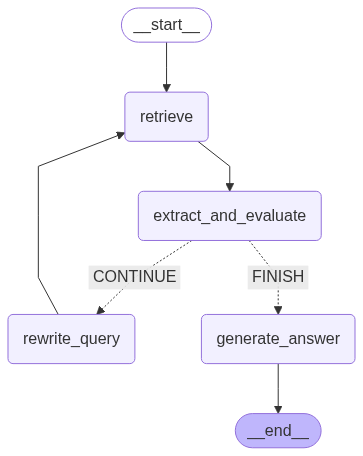

In [34]:
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

# 그래프 객체 생성
# 그래프 객체의 상태 객체는 개인 정보 보호법 검색 AGENT 상태 관리 객체 
workflow = StateGraph(PersonalRagState)

# 노드 추가
# 벡터 검색, 문서 평가 및 우수한 정보 조작 선별, 더 좋은 결과를 위해서 질문 개선, 응답 생성 노드 
workflow.add_node("retrieve", retrieve_documents)
workflow.add_node("extract_and_evaluate", extract_and_evaluate_information)
workflow.add_node("rewrite_query", rewrite_query)
workflow.add_node("generate_answer", generate_node_answer)

# 엣지 추가
# 1 시작 >> 2 추출 >> 3 평가
workflow.add_edge(START, "retrieve")
workflow.add_edge("retrieve", "extract_and_evaluate")

# 조건부 엣지 추가
#  3 평가 >> 4 조건부 분기 > 계속 또는 종료 
# 4.1 계속 >> 5 질문 개선, 4.2 종료 >> 6 응답 생성
workflow.add_conditional_edges(
    "extract_and_evaluate",
    should_continue,
    {
        "CONTINUE": "rewrite_query",
        "FINISH": "generate_answer"
    }
)
# 엣지 추가
# 5 질문 개선 >> 2 추출 >> ...
# 6 응답 생성 >> END
workflow.add_edge("rewrite_query", "retrieve")
workflow.add_edge("generate_answer", END)

# 그래프 컴파일
personal_law_agent = workflow.compile()

# 그래프 시각화
display(Image(personal_law_agent.get_graph().draw_mermaid_png()))

In [35]:

# 그래프 시각화 로컬 파일 생성

# display(Image(personal_law_agent.get_graph().draw_mermaid_png()))
mermaid_code = personal_law_agent.get_graph().draw_mermaid()

# Save to a file
with open("personal_law_agent.md", "w") as f:
    f.write("```mermaid\n")
    f.write(mermaid_code)
    f.write("\n```")

In [36]:
inputs = {"question": "개인정보 처리에 대한 동의를 받을 때 주의해야 할 점은 무엇인가요?"}
for output in personal_law_agent.stream(inputs):
    for key, value in output.items():
        # 노드 출력
        pprint(f"Node '{key}':")
        pprint(f"Value: {value}", indent=2, width=80, depth=None)
    print("\n----------------------------------------------------------\n")

---문서 검색---


Failed to send telemetry event CollectionQueryEvent: capture() takes 1 positional argument but 3 were given


"Node 'retrieve':"
("Value: {'documents': [Document(metadata={'chapter': '제3장 개인정보의 처리\\n         "
 "제1절 개인정보의 수집, 이용, 제공 등', 'name': '개인정보 보호법', 'source': 'data\\\\개인정보 "
 "보호법(법률)(제19234호)(20240315).pdf'}, page_content='[법률정보]\\n다음 조항은 개인정보 보호법 제3장 "
 '개인정보의 처리\\n         제1절 개인정보의 수집, 이용, 제공 등에서 발췌한 '
 '내용입니다.\\n\\n[법률조항]\\n제15조(개인정보의 수집ㆍ이용) ① 개인정보처리자는 다음 각 호의 어느 하나에 해당하는 경우에는 '
 '개인정보를 수집할\\n수 있으며 그 수집 목적의 범위에서 이용할 수 있다. <개정 2023. 3. 14.>\\n1. 정보주체의 동의를 '
 '받은 경우\\n2. 법률에 특별한 규정이 있거나 법령상 의무를 준수하기 위하여 불가피한 경우\\n3. 공공기관이 법령 등에서 정하는 소관 '
 '업무의 수행을 위하여 불가피한 경우\\n4. 정보주체와 체결한 계약을 이행하거나 계약을 체결하는 과정에서 정보주체의 요청에 따른 조치를 '
 '이행하기 위하\\n여 필요한 경우 \\n5. 명백히 정보주체 또는 제3자의 급박한 생명, 신체, 재산의 이익을 위하여 필요하다고 인정되는 '
 '경우\\n6. 개인정보처리자의 정당한 이익을 달성하기 위하여 필요한 경우로서 명백하게 정보주체의 권리보다 우선하는 경\\n우. 이 경우 '
 '개인정보처리자의 정당한 이익과 상당한 관련이 있고 합리적인 범위를 초과하지 아니하는 경우에 한 \\n한다. \\n7. 공중위생 등 공공의 '
 '안전과 안녕을 위하여 긴급히 필요한 경우\\n② 개인정보처리자는 제1항제1호에 따른 동의를 받을 때에는 다음 각 호의 사항을 정보주체에게 '
 '알려야 한다. 다음\\n각 호의 어느 하나의 사항을 변경하는 경우에도 이를 알리고 동의를

In [ ]:
print(value['node_answer'])

`(2) 근로기준법 RAG 에이전트`

In [36]:
# 근로기준법 검색 에이전드 상태 관리 클래스
# CRAG 상태 관리 클래스 상속
class LaborRagState(CorrectiveRagState):
    rewritten_query: str   # 재작성한 질문 
    extracted_info: Optional[ExtractedInformation]   # 추출된 정보 조각 
    node_answer: Optional[str] 

In [37]:
from langchain_core.prompts import ChatPromptTemplate
from typing import Literal
# 문서 검색 하는 노드
# in : 근로기준법 검색 AGENT 상태 관리 객체 
# out: 근로기준법 검색 AGENT 상태 관리 객체   
def retrieve_documents(state: LaborRagState) -> LaborRagState:
    print("---문서 검색---")
    query = state.get("rewritten_query", state["question"])
    docs = labor_law_search.invoke(query)
    return {"documents": docs}

def extract_and_evaluate_information(state: LaborRagState) -> LaborRagState:
    print("---정보 추출 및 평가---")
    extracted_strips = []

    for doc in state["documents"]:
        extract_prompt = ChatPromptTemplate.from_messages([
            ("system", """당신은 근로기준법 전문가입니다. 주어진 문서에서 질문과 관련된 주요 사실과 정보를 3~5개 정도 추출하세요. 
            각 추출된 정보에 대해 다음 두 가지 측면을 0에서 1 사이의 점수로 평가하세요:
            1. 질문과의 관련성
            2. 답변의 충실성 (질문에 대한 완전하고 정확한 답변을 제공할 수 있는 정도)
            
            추출 형식:
            1. [추출된 정보]
            - 관련성 점수: [0-1 사이의 점수]
            - 충실성 점수: [0-1 사이의 점수]
            2. [추출된 정보]
            - 관련성 점수: [0-1 사이의 점수]
            - 충실성 점수: [0-1 사이의 점수]
            ...
            
            마지막으로, 추출된 정보를 종합하여 질문에 대한 전반적인 답변 가능성을 0에서 1 사이의 점수로 평가하세요."""),
            ("human", "[질문]\n{question}\n\n[문서 내용]\n{document_content}")
        ])

        extract_llm = llm.with_structured_output(ExtractedInformation)

        extracted_data = extract_llm.invoke(extract_prompt.format(
            question=state["question"],
            document_content=doc.page_content
        ))

        if extracted_data.query_relevance < 0.8:
            continue

        for strip in extracted_data.strips:
            if strip.relevance_score > 0.7 and strip.faithfulness_score > 0.7:
                extracted_strips.append(strip)

    return {
        "extracted_info": extracted_strips,
        "num_generations": state.get("num_generations", 0) + 1
    }

def rewrite_query(state: LaborRagState) -> LaborRagState:
    print("---쿼리 재작성---")

    rewrite_prompt = ChatPromptTemplate.from_messages([
        ("system", """당신은 근로기준법 전문가입니다. 주어진 원래 질문과 추출된 정보를 바탕으로, 더 관련성 있고 충실한 정보를 찾기 위해 검색 쿼리를 개선해주세요.

        다음 사항을 고려하여 검색 쿼리를 개선하세요:
        1. 원래 질문의 핵심 요소
        2. 추출된 정보의 관련성 점수
        3. 추출된 정보의 충실성 점수
        4. 부족한 정보나 더 자세히 알아야 할 부분

        개선된 검색 쿼리 작성 단계:
        1. 2-3개의 검색 쿼리를 제안하세요.
        2. 각 쿼리는 구체적이고 간결해야 합니다(5-10 단어 사이).
        3. 근로기준법과 관련된 전문 용어를 적절히 활용하세요.
        4. 각 쿼리 뒤에는 해당 쿼리를 제안한 이유를 간단히 설명하세요.

        출력 형식:
        1. [개선된 검색 쿼리 1]
        - 이유: [이 쿼리를 제안한 이유 설명]
        2. [개선된 검색 쿼리 2]
        - 이유: [이 쿼리를 제안한 이유 설명]
        3. [개선된 검색 쿼리 3]
        - 이유: [이 쿼리를 제안한 이유 설명]

        마지막으로, 제안된 쿼리 중 가장 효과적일 것 같은 쿼리를 선택하고 그 이유를 설명하세요."""),
        ("human", "원래 질문: {question}\n\n추출된 정보:\n{extracted_info}\n\n위 지침에 따라 개선된 검색 쿼리를 작성해주세요.")
    ])

    extracted_info_str = "\n".join([strip.content for strip in state["extracted_info"]])
    
    rewrite_llm = llm.with_structured_output(RefinedQuestion)

    response = rewrite_llm.invoke(rewrite_prompt.format(
        question=state["question"],
        extracted_info=extracted_info_str
    ))
    
    return {"rewritten_query": response.question_refined}

def generate_node_answer(state: LaborRagState) -> LaborRagState:
    print("---답변 생성---")

    answer_prompt = ChatPromptTemplate.from_messages([
        ("system", """당신은 근로기준법 전문가입니다. 주어진 질문과 추출된 정보를 바탕으로 답변을 생성해주세요. 
        답변은 마크다운 형식으로 작성하며, 각 정보의 출처를 명확히 표시해야 합니다. 
        답변 구조:
        1. 질문에 대한 직접적인 답변
        2. 관련 법률 조항 및 해석
        3. 추가 설명 또는 예시 (필요한 경우)
        4. 결론 및 요약
        각 섹션에서 사용된 정보의 출처를 괄호 안에 명시하세요. 예: (출처: 근로기준법 제15조)"""),
        ("human", "질문: {question}\n\n추출된 정보:\n{extracted_info}\n\n위 지침에 따라 최종 답변을 작성해주세요.")
    ])

    extracted_info_str = "\n".join([f"내용: {strip.content}\n출처: {strip.source}\n관련성: {strip.relevance_score}\n충실성: {strip.faithfulness_score}" for strip in state["extracted_info"]])

    node_answer = llm.invoke(answer_prompt.format(
        question=state["question"],
        extracted_info=extracted_info_str
    ))

    return {"node_answer": node_answer.content}

def should_continue(state: LaborRagState) -> Literal["CONTINUE", "FINISH"]:
    if state["num_generations"] >= 2:
        return "FINISH"
    if len(state["extracted_info"]) >= 1:
        return "FINISH"
    return "CONTINUE"

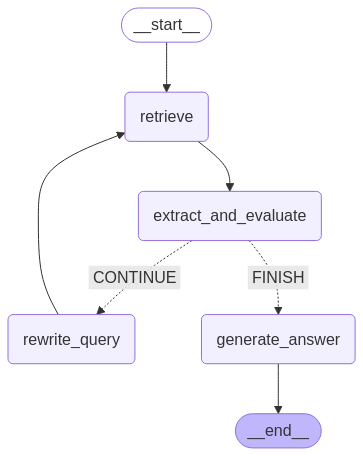

In [38]:
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

# 그래프 생성
workflow = StateGraph(LaborRagState)

# 노드 추가
workflow.add_node("retrieve", retrieve_documents)
workflow.add_node("extract_and_evaluate", extract_and_evaluate_information)
workflow.add_node("rewrite_query", rewrite_query)
workflow.add_node("generate_answer", generate_node_answer)


# 엣지 추가
workflow.add_edge(START, "retrieve")
workflow.add_edge("retrieve", "extract_and_evaluate")

# 조건부 엣지 추가
workflow.add_conditional_edges(
    "extract_and_evaluate",
    should_continue,
    {
        "CONTINUE": "rewrite_query",
        "FINISH": "generate_answer"
    }
)
workflow.add_edge("rewrite_query", "retrieve")
workflow.add_edge("generate_answer", END)

# 그래프 컴파일
labor_law_agent = workflow.compile()

# 그래프 시각화
display(Image(labor_law_agent.get_graph().draw_mermaid_png()))

In [ ]:
inputs = {"question": "근로계약 체결할 때 주의해야 할 점은 무엇인가요?"}
for output in labor_law_agent.stream(inputs):
    for key, value in output.items():
        # 노드 출력
        pprint(f"Node '{key}':")
        pprint(f"Value: {value}", indent=2, width=80, depth=None)
    print("\n----------------------------------------------------------\n")

In [ ]:
print(value['node_answer'])

`(3) 주택임대차보호법 RAG 에이전트`

In [39]:
# 주택임대차보호법
class HousingRagState(CorrectiveRagState):
    rewritten_query: str   # 재작성한 질문 
    extracted_info: Optional[ExtractedInformation]   # 추출된 정보 조각 
    node_answer: Optional[str] 

In [40]:
from langchain_core.prompts import ChatPromptTemplate
from typing import Literal

def retrieve_documents(state: HousingRagState) -> HousingRagState:
    print("---문서 검색---")
    query = state.get("rewritten_query", state["question"])
    docs = housing_law_search.invoke(query)
    return {"documents": docs}

def extract_and_evaluate_information(state: HousingRagState) -> HousingRagState:
    print("---정보 추출 및 평가---")
    extracted_strips = []

    for doc in state["documents"]:
        extract_prompt = ChatPromptTemplate.from_messages([
            ("system", """당신은 주택임대차보호법 전문가입니다. 주어진 문서에서 질문과 관련된 주요 사실과 정보를 3~5개 정도 추출하세요. 
            각 추출된 정보에 대해 다음 두 가지 측면을 0에서 1 사이의 점수로 평가하세요:
            1. 질문과의 관련성
            2. 답변의 충실성 (질문에 대한 완전하고 정확한 답변을 제공할 수 있는 정도)
            
            추출 형식:
            1. [추출된 정보]
            - 관련성 점수: [0-1 사이의 점수]
            - 충실성 점수: [0-1 사이의 점수]
            2. [추출된 정보]
            - 관련성 점수: [0-1 사이의 점수]
            - 충실성 점수: [0-1 사이의 점수]
            ...
            
            마지막으로, 추출된 정보를 종합하여 질문에 대한 전반적인 답변 가능성을 0에서 1 사이의 점수로 평가하세요."""),
            ("human", "[질문]\n{question}\n\n[문서 내용]\n{document_content}")
        ])

        extract_llm = llm.with_structured_output(ExtractedInformation)

        extracted_data = extract_llm.invoke(extract_prompt.format(
            question=state["question"],
            document_content=doc.page_content
        ))

        if extracted_data.query_relevance < 0.8:
            continue

        for strip in extracted_data.strips:
            if strip.relevance_score > 0.7 and strip.faithfulness_score > 0.7:
                extracted_strips.append(strip)

    return {
        "extracted_info": extracted_strips,
        "num_generations": state.get("num_generations", 0) + 1
    }

def rewrite_query(state: HousingRagState) -> HousingRagState:
    print("---쿼리 재작성---")

    rewrite_prompt = ChatPromptTemplate.from_messages([
        ("system", """당신은 주택임대차보호법 전문가입니다. 주어진 원래 질문과 추출된 정보를 바탕으로, 더 관련성 있고 충실한 정보를 찾기 위해 검색 쿼리를 개선해주세요.

        다음 사항을 고려하여 검색 쿼리를 개선하세요:
        1. 원래 질문의 핵심 요소
        2. 추출된 정보의 관련성 점수
        3. 추출된 정보의 충실성 점수
        4. 부족한 정보나 더 자세히 알아야 할 부분

        개선된 검색 쿼리 작성 단계:
        1. 2-3개의 검색 쿼리를 제안하세요.
        2. 각 쿼리는 구체적이고 간결해야 합니다(5-10 단어 사이).
        3. 주택임대차보호법과 관련된 전문 용어를 적절히 활용하세요.
        4. 각 쿼리 뒤에는 해당 쿼리를 제안한 이유를 간단히 설명하세요.

        출력 형식:
        1. [개선된 검색 쿼리 1]
        - 이유: [이 쿼리를 제안한 이유 설명]
        2. [개선된 검색 쿼리 2]
        - 이유: [이 쿼리를 제안한 이유 설명]
        3. [개선된 검색 쿼리 3]
        - 이유: [이 쿼리를 제안한 이유 설명]

        마지막으로, 제안된 쿼리 중 가장 효과적일 것 같은 쿼리를 선택하고 그 이유를 설명하세요."""),
        ("human", "원래 질문: {question}\n\n추출된 정보:\n{extracted_info}\n\n위 지침에 따라 개선된 검색 쿼리를 작성해주세요.")
    ])

    extracted_info_str = "\n".join([strip.content for strip in state["extracted_info"]])
    
    rewrite_llm = llm.with_structured_output(RefinedQuestion)

    response = rewrite_llm.invoke(rewrite_prompt.format(
        question=state["question"],
        extracted_info=extracted_info_str
    ))
    
    return {"rewritten_query": response.question_refined}

def generate_node_answer(state: HousingRagState) -> HousingRagState:
    print("---답변 생성---")

    answer_prompt = ChatPromptTemplate.from_messages([
        ("system", """당신은 주택임대차보호법 전문가입니다. 주어진 질문과 추출된 정보를 바탕으로 답변을 생성해주세요. 
        답변은 마크다운 형식으로 작성하며, 각 정보의 출처를 명확히 표시해야 합니다. 
        답변 구조:
        1. 질문에 대한 직접적인 답변
        2. 관련 법률 조항 및 해석
        3. 추가 설명 또는 예시 (필요한 경우)
        4. 결론 및 요약
        각 섹션에서 사용된 정보의 출처를 괄호 안에 명시하세요. 예: (출처: 주택임대차보호법 제15조)"""),
        ("human", "질문: {question}\n\n추출된 정보:\n{extracted_info}\n\n위 지침에 따라 최종 답변을 작성해주세요.")
    ])

    extracted_info_str = "\n".join([f"내용: {strip.content}\n출처: {strip.source}\n관련성: {strip.relevance_score}\n충실성: {strip.faithfulness_score}" for strip in state["extracted_info"]])

    node_answer = llm.invoke(answer_prompt.format(
        question=state["question"],
        extracted_info=extracted_info_str
    ))

    return {"node_answer": node_answer.content}

def should_continue(state: HousingRagState) -> Literal["CONTINUE", "FINISH"]:
    if state["num_generations"] >= 2:
        return "FINISH"
    if len(state["extracted_info"]) >= 1:
        return "FINISH"
    return "CONTINUE"

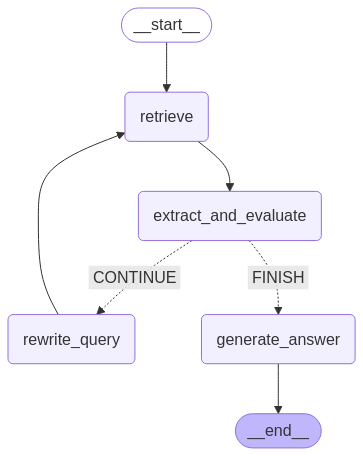

In [41]:
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

# 그래프 생성
workflow = StateGraph(HousingRagState)

# 노드 추가
workflow.add_node("retrieve", retrieve_documents)
workflow.add_node("extract_and_evaluate", extract_and_evaluate_information)
workflow.add_node("rewrite_query", rewrite_query)
workflow.add_node("generate_answer", generate_node_answer)


# 엣지 추가
workflow.add_edge(START, "retrieve")
workflow.add_edge("retrieve", "extract_and_evaluate")

# 조건부 엣지 추가
workflow.add_conditional_edges(
    "extract_and_evaluate",
    should_continue,
    {
        "CONTINUE": "rewrite_query",
        "FINISH": "generate_answer"
    }
)
workflow.add_edge("rewrite_query", "retrieve")
workflow.add_edge("generate_answer", END)

# 그래프 컴파일
housing_law_agent = workflow.compile()

# 그래프 시각화
display(Image(housing_law_agent.get_graph().draw_mermaid_png()))

In [ ]:
inputs = {"question": "대리인과 아파트 임대차 계약을 체결할 때 주의해야 할 점은 무엇인가요?"}
for output in housing_law_agent.stream(inputs):
    for key, value in output.items():
        # 노드 출력
        pprint(f"Node '{key}':")
        pprint(f"Value: {value}", indent=2, width=80, depth=None)
    print("\n----------------------------------------------------------\n")

In [ ]:
print(value['node_answer'])

`(4) 웹 검색 기반 RAG 에이전트`

In [42]:
# 웹 검색 도구 
class SearchRagState(CorrectiveRagState):
    rewritten_query: str   # 재작성한 질문 
    extracted_info: Optional[ExtractedInformation]   # 추출된 정보 조각 
    node_answer: Optional[str] 

In [43]:
from langchain_core.prompts import ChatPromptTemplate
from typing import Literal

def retrieve_documents(state: SearchRagState) -> SearchRagState:
    print("---문서 검색---")
    query = state.get("rewritten_query", state["question"])
    docs = web_search.invoke(query)
    return {"documents": docs}

def extract_and_evaluate_information(state: SearchRagState) -> SearchRagState:
    print("---정보 추출 및 평가---")
    extracted_strips = []

    for doc in state["documents"]:
        extract_prompt = ChatPromptTemplate.from_messages([
            ("system", """당신은 인터넷 정보 검색 전문가입니다. 주어진 문서에서 질문과 관련된 주요 사실과 정보를 3~5개 정도 추출하세요. 
            각 추출된 정보에 대해 다음 두 가지 측면을 0에서 1 사이의 점수로 평가하세요:
            1. 질문과의 관련성
            2. 답변의 충실성 (질문에 대한 완전하고 정확한 답변을 제공할 수 있는 정도)
            
            추출 형식:
            1. [추출된 정보]
            - 관련성 점수: [0-1 사이의 점수]
            - 충실성 점수: [0-1 사이의 점수]
            2. [추출된 정보]
            - 관련성 점수: [0-1 사이의 점수]
            - 충실성 점수: [0-1 사이의 점수]
            ...
            
            마지막으로, 추출된 정보를 종합하여 질문에 대한 전반적인 답변 가능성을 0에서 1 사이의 점수로 평가하세요."""),
            ("human", "[질문]\n{question}\n\n[문서 내용]\n{document_content}")
        ])

        extract_llm = llm.with_structured_output(ExtractedInformation)

        extracted_data = extract_llm.invoke(extract_prompt.format(
            question=state["question"],
            document_content=doc.page_content
        ))

        if extracted_data.query_relevance < 0.8:
            continue

        for strip in extracted_data.strips:
            if strip.relevance_score > 0.7 and strip.faithfulness_score > 0.7:
                extracted_strips.append(strip)

    return {
        "extracted_info": extracted_strips,
        "num_generations": state.get("num_generations", 0) + 1
    }

def rewrite_query(state: SearchRagState) -> SearchRagState:
    print("---쿼리 재작성---")

    rewrite_prompt = ChatPromptTemplate.from_messages([
        ("system", """당신은 인터넷 정보 검색 전문가입니다. 주어진 원래 질문과 추출된 정보를 바탕으로, 더 관련성 있고 충실한 정보를 찾기 위해 검색 쿼리를 개선해주세요.

        다음 사항을 고려하여 검색 쿼리를 개선하세요:
        1. 원래 질문의 핵심 요소
        2. 추출된 정보의 관련성 점수
        3. 추출된 정보의 충실성 점수
        4. 부족한 정보나 더 자세히 알아야 할 부분

        개선된 검색 쿼리 작성 단계:
        1. 2-3개의 검색 쿼리를 제안하세요.
        2. 각 쿼리는 구체적이고 간결해야 합니다(5-10 단어 사이).
        3. 질문과 관련된 전문 용어를 적절히 활용하세요.
        4. 각 쿼리 뒤에는 해당 쿼리를 제안한 이유를 간단히 설명하세요.

        출력 형식:
        1. [개선된 검색 쿼리 1]
        - 이유: [이 쿼리를 제안한 이유 설명]
        2. [개선된 검색 쿼리 2]
        - 이유: [이 쿼리를 제안한 이유 설명]
        3. [개선된 검색 쿼리 3]
        - 이유: [이 쿼리를 제안한 이유 설명]

        마지막으로, 제안된 쿼리 중 가장 효과적일 것 같은 쿼리를 선택하고 그 이유를 설명하세요."""),
        ("human", "원래 질문: {question}\n\n추출된 정보:\n{extracted_info}\n\n위 지침에 따라 개선된 검색 쿼리를 작성해주세요.")
    ])

    extracted_info_str = "\n".join([strip.content for strip in state["extracted_info"]])
    
    rewrite_llm = llm.with_structured_output(RefinedQuestion)

    response = rewrite_llm.invoke(rewrite_prompt.format(
        question=state["question"],
        extracted_info=extracted_info_str
    ))
    
    return {"rewritten_query": response.question_refined}

def generate_node_answer(state: SearchRagState) -> SearchRagState:
    print("---답변 생성---")

    answer_prompt = ChatPromptTemplate.from_messages([
        ("system", """당신은 인터넷 정보 검색 전문가입니다. 주어진 질문과 추출된 정보를 바탕으로 답변을 생성해주세요. 
        답변은 마크다운 형식으로 작성하며, 각 정보의 출처를 명확히 표시해야 합니다. 
        답변 구조:
        1. 질문에 대한 직접적인 답변
        2. 관련 출처 및 링크
        3. 추가 설명 또는 예시 (필요한 경우)
        4. 결론 및 요약
        각 섹션에서 사용된 정보의 출처를 괄호 안에 명시하세요. 예: (출처: 블로그 (www.blog.com/page/001)"""),
        ("human", "질문: {question}\n\n추출된 정보:\n{extracted_info}\n\n위 지침에 따라 최종 답변을 작성해주세요.")
    ])

    extracted_info_str = "\n".join([f"내용: {strip.content}\n출처: {strip.source}\n관련성: {strip.relevance_score}\n충실성: {strip.faithfulness_score}" for strip in state["extracted_info"]])

    node_answer = llm.invoke(answer_prompt.format(
        question=state["question"],
        extracted_info=extracted_info_str
    ))

    return {"node_answer": node_answer.content}

def should_continue(state: SearchRagState) -> Literal["CONTINUE", "FINISH"]:
    if state["num_generations"] >= 2:
        return "FINISH"
    if len(state["extracted_info"]) >= 1:
        return "FINISH"
    return "CONTINUE"

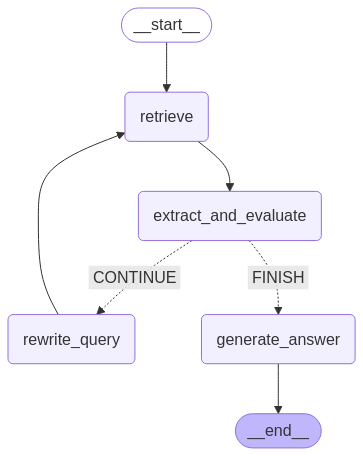

In [44]:
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

# 그래프 생성
workflow = StateGraph(SearchRagState)

# 노드 추가
workflow.add_node("retrieve", retrieve_documents)
workflow.add_node("extract_and_evaluate", extract_and_evaluate_information)
workflow.add_node("rewrite_query", rewrite_query)
workflow.add_node("generate_answer", generate_node_answer)


# 엣지 추가
workflow.add_edge(START, "retrieve")
workflow.add_edge("retrieve", "extract_and_evaluate")

# 조건부 엣지 추가
workflow.add_conditional_edges(
    "extract_and_evaluate",
    should_continue,
    {
        "CONTINUE": "rewrite_query",
        "FINISH": "generate_answer"
    }
)
workflow.add_edge("rewrite_query", "retrieve")
workflow.add_edge("generate_answer", END)

# 그래프 컴파일
search_web_agent = workflow.compile()

# 그래프 시각화
display(Image(search_web_agent.get_graph().draw_mermaid_png()))

In [ ]:
inputs = {"question": "대리인과 아파트 임대차 계약을 체결할 때 주의해야 할 점은 무엇인가요?"}
for output in search_web_agent.stream(inputs):
    for key, value in output.items():
        # 노드 출력
        pprint(f"Node '{key}':")
        pprint(f"Value: {value}", indent=2, width=80, depth=None)
    print("\n----------------------------------------------------------\n")

In [ ]:
print(value['node_answer'])

### 4-2. 질문 라우팅 
- 사용자의 질문을 분석하여 적절한 에이전트를 선택 (Adaptive RAG 적용)

In [51]:
from typing import Annotated
from operator import add

# 메인 그래프 상태 정의
# 리서치 AGENT 상태 관리 클래스
class ResearchAgentState(TypedDict):
    question: str
    #질문을 저장하는 문자열 타입의 필드
    answers: Annotated[List[str], add]
    #여러 개의 응답을 저장하기 위한 리스트 타입의 필드. Annotated를 사용하여 추가 메타 데이터인 add 연산자를 부여. 
    # 이 메타 데이터는 특정 동작을 나타 내기 위해 추가
    final_answer: str
    #최종 답변을 저장 하는 문자열 타입의 필드
    datasources: List[str]
    #데이터 소스들의 리스트를 저장
    evaluation_report: Optional[dict]
    #평가 보고서를 저장하는 딕셔너리 옵션 필드. 이 값은 선택적이며, 존재하지 않을 수도 있음
    user_decision: Optional[str]
    #사용자의 결정을 저장하는 선택적 필드. 이 값 또한 존재하지 않을 수 있음


In [46]:
from typing import Literal
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field

# 라우팅 결정을 위한 데이터 모델 
# 사용자 질문을 가장 적합한 도구로 라우팅 하기 위해 데이터 모델을 정의 

# ToolSelector 클래스는 BaseModel을 상속받아 사용자 질문을 가장 적합한 도구로 라우팅하기 위한 데이터 모델을 정의
# tool 속성은 Literal 타입으로, "search_personal", "search_labor", "search_housing", "search_web" 중 하나의 값만 가질 수 있음
# Field 함수의 description 인자는 tool 속성에 대한 설명으로, "사용자의 질문에 따라 도구 중 하나를 선택한다"는 의미

class ToolSelector(BaseModel):
    """Routes the user question to the most appropriate tool."""
    tool: Literal["search_personal", "search_labor", "search_housing", "search_web"] = Field(
        description="Select one of the tools, based on the user's question.",
    )
    
# ToolSelectors 클래스는 BaseModel을 상속받아 사용자 질문에 적합한 도구들을 선택하기 위한 데이터 모델을 정의
# tools 속성은 여러 개의 ToolSelector 객체들을 포함하는 리스트
# Field 함수의 description 인자는 tools 속성에 대한 설명으로, "사용자의 질문에 따라 하나 이상의 도구를 선택한다"는 의미
# 이 모델들을 통해 사용자 질문에 맞는 도구를 결정하고, 여러 도구를 사용할 경우 그 리스트를 정의

class ToolSelectors(BaseModel):
    """Select the appropriate tools that are suitable for the user question."""
    tools: List[ToolSelector] = Field(
        description="Select one or more tools, based on the user's question.",
    )

# 구조화된 출력을 위한 LLM 설정
structured_llm_tool_selector = llm.with_structured_output(ToolSelectors)

# 라우팅을 위한 프롬프트 템플릿
system = dedent("""You are an AI assistant specializing in routing user questions to the appropriate tools.
Use the following guidelines:
- For questions specifically about legal provisions or articles of the privacy protection law (개인정보 보호법), use the search_personal tool.
- For questions specifically about legal provisions or articles of the labor law (근로기준법), use the search_labor tool.
- For questions specifically about legal provisions or articles of the housing law (주택임대차보호법), use the search_housing tool.
- For any other information, including questions related to these laws but not directly about specific legal provisions, or for the most up-to-date data, use the search_web tool.
Always choose all of the appropriate tools based on the user's question. 
If a question is about a law but doesn't seem to be asking about specific legal provisions, include both the relevant law search tool and the search_web tool.""")

route_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "{question}"),
    ]
)

# 질문 라우터 체인 정의
question_tool_router = route_prompt | structured_llm_tool_selector



In [47]:
# 테스트 체인 실행
print(question_tool_router.invoke({"question": "근로계약 체결할 때 개인정보 취급 상의 유의사항은 무엇인가요?"}))
print(question_tool_router.invoke({"question": "법에서 정한 연차휴가 기준을 알려주세요."}))
print(question_tool_router.invoke({"question": "개인정보보호법에서 정한 가명정보의 정의는 무엇인가요?"}))

tools=[ToolSelector(tool='search_personal'), ToolSelector(tool='search_web')]
tools=[ToolSelector(tool='search_labor')]
tools=[ToolSelector(tool='search_personal')]


In [48]:
# 노드 정의 
# 질문 라우팅 노드 

# 질문에 적절한 agent 선택 노드 
# in:  question 리서치 AGENT 상태 관리 객체, out: 리서치 AGENT 상태 관리 객체
def analyze_question_tool_search(state: ResearchAgentState):
    # 상태 관리 객체 에서 질문 추출
    question = state["question"]
    # 질문 라우터 체인 실행
    result = question_tool_router.invoke({"question": question})
    # 선택된 도구 리스트 에서 도구 이름만 리스트 형태로 datasources 상태에 저장 
    datasources = [tool.tool for tool in result.tools]
    return {"datasources": datasources}

#  선택된 AGENT 명칭의 유효성 검사 노드 
#  in:  question 리서치 AGENT 상태 관리 객체, out:  문자열의 리스트(List[str])
def route_datasources_tool_search(state: ResearchAgentState) -> List[str]:
    #state는 리서치 AGENT 상태 관리 객체 로서 'datasources' 라는 키의 값을 가져와 datasources 변수에 저장
    # 이 값은 중복을 제거 하기 위해 set 자료 형으로 변환
    datasources = set(state['datasources'])
    valid_sources = {"search_personal", "search_labor", "search_housing", "search_web"}
    
    #만약 datasources 집합이 valid_sources 집합의 부분 집합 이면, 즉 datasources 모든 요소가 유효한 데이터 소스에 포함 되면 datasources 요소를 리스트 형태로 리턴 함, 아니면 valid_sources 요소를 리스트 형태로 리턴함
    if datasources.issubset(valid_sources):
        return list(datasources)
    
    return list(valid_sources)

In [50]:
# 노드 정의 
# 앞선 그래프 객체를 노드로 정의 함
# input : 매개변수는 기본값으로 ResearchAgentState를 가지며, OUTPUT: ResearchAgentState
def personal_rag_node(state: PersonalRagState, input=ResearchAgentState) -> ResearchAgentState:
    print("--- 개인정보보호법 전문가 에이전트 시작 ---")
    # ResearchAgentState question INPUT
    question = state["question"]
    # personal_rag_node INVOKE
    answer = personal_law_agent.invoke({"question": question})
    # PersonalRagState "node_answer"
    return {"answers": [answer["node_answer"]]}

def labor_rag_node(state: LaborRagState, input=ResearchAgentState) -> ResearchAgentState:
    print("--- 근로기준법 전문가 에이전트 시작 ---")
    question = state["question"]
    answer = labor_law_agent.invoke({"question": question})
    return {"answers": [answer["node_answer"]]}

def housing_rag_node(state: HousingRagState, input=ResearchAgentState) -> ResearchAgentState:
    print("--- 주택임대차보호법 전문가 에이전트 시작 ---")
    question = state["question"]
    answer = housing_law_agent.invoke({"question": question})
    return {"answers": [answer["node_answer"]]}

def web_rag_node(state: SearchRagState, input=ResearchAgentState) -> ResearchAgentState:
    print("--- 인터넷 검색 전문가 에이전트 시작 ---")
    question = state["question"]
    answer = search_web_agent.invoke({"question": question})
    return {"answers": [answer["node_answer"]]}


In [52]:
# 최종 답변 생성 노드
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate

# RAG 프롬프트 정의
rag_prompt = ChatPromptTemplate.from_messages([
    ("system", """You are an assistant answering questions based on provided documents. Follow these guidelines:

1. Use only information from the given documents.
2. If the document lacks relevant info, say "제공된 정보로는 충분한 답변을 할 수 없습니다."
3. Cite the source of information for each sentence in your answer. Use the following format:
    - For legal articles: "법률명 제X조 Y항"
    - For web sources: "출처 제목 (URL)"
4. Don't speculate or add information not in the documents.
5. Keep answers concise and clear.
6. Omit irrelevant information.
7. If multiple sources provide the same information, cite all relevant sources.
8. If information comes from multiple sources, combine them coherently while citing each source.

Example of citation usage:
"부동산 거래 시 계약서에 거래 금액을 명시해야 합니다 (부동산 거래신고 등에 관한 법률 제3조 1항). 또한, 계약 체결일로부터 30일 이내에 신고해야 합니다 (부동산 거래 신고 안내 블로그, https://example.com/realestate)."
"""
    ),
    ("human", "Answer the following question using these documents:\n\n[Documents]\n{documents}\n\n[Question]\n{question}"),
])

# 최종 답변 생성 노드 
# input : 매개변수 기본값 ResearchAgentState 가지며, OUTPUT: ResearchAgentState
def answer_final(state: ResearchAgentState) -> ResearchAgentState:
    """
    Generate answer using the retrieved_documents
    """
    print("---최종 답변---")
    question = state["question"]
    documents = state.get("answers", [])
    if not isinstance(documents, list):
        documents = [documents]

    # 문서 내용을 문자열로 결합 
    documents_text = "\n\n".join(documents)

    # 체인 생성 RAG generation
    rag_chain = rag_prompt | llm | StrOutputParser()
    # 체인 실행 
    # 각 하위 AGENT 응답 취합한 문서 텍스트 와 사용자 질문을 입력
    generation = rag_chain.invoke({"documents": documents_text, "question": question})
    # ResearchAgentState UPDATE
    return {"final_answer": generation, "question":question}


# LLM Fallback 프롬프트 정의
fallback_prompt = ChatPromptTemplate.from_messages([
    ("system", """You are an AI assistant helping with various topics. Follow these guidelines:

1. Provide accurate and helpful information to the best of your ability.
2. Express uncertainty when unsure; avoid speculation.
3. Keep answers concise yet informative.
4. Respond ethically and constructively.
5. Mention reliable general sources when applicable."""),
    ("human", "{question}"),
])
# Fallback 노드
# input : 매개변수 기본값 ResearchAgentState 가지며, OUTPUT: ResearchAgentState
def llm_fallback(state: ResearchAgentState) -> ResearchAgentState:
    """
    Generate answer using the LLM without context
    """
    print("---Fallback 답변---")
    question = state["question"]
    
    # LLM chain
    llm_chain = fallback_prompt | llm | StrOutputParser()
    
    generation = llm_chain.invoke({"question": question})
    return {"final_answer": generation, "question":question}

In [53]:
# 노드 정의를 딕셔너리로 관리
nodes = {
    "analyze_question": analyze_question_tool_search,
    "search_personal": personal_rag_node,
    "search_labor": labor_rag_node,
    "search_housing": housing_rag_node,
    "search_web": web_rag_node,
    "generate_answer": answer_final,
    "llm_fallback": llm_fallback
}

# AGENT 그래프 생성을 위한 StateGraph 객체를 정의
search_builder = StateGraph(ResearchAgentState)

# 노드 추가 (반복 정의 LOOP)
for node_name, node_func in nodes.items():
    search_builder.add_node(node_name, node_func)

# 엣지 추가 (병렬 처리)
search_builder.add_edge(START, "analyze_question")
# 조건부 분기 엣지 추가
search_builder.add_conditional_edges(
    "analyze_question",
    route_datasources_tool_search,
    ["search_personal", "search_labor", "search_housing", "search_web", "llm_fallback"]
)

# 4가지 검색 노드 각각 >> generate_answer 연결
for node in ["search_personal", "search_labor", "search_housing", "search_web"]:
    search_builder.add_edge(node, "generate_answer")
# generate_answer >> END, llm_fallback >> END
search_builder.add_edge("generate_answer", END)
search_builder.add_edge("llm_fallback", END)

# 그래프 컴파일
rag_search_graph = search_builder.compile()

# 그래프 시각화 
display(Image(rag_search_graph.get_graph().draw_mermaid_png()))

ReadTimeout: HTTPSConnectionPool(host='mermaid.ink', port=443): Read timed out. (read timeout=10)

In [54]:
# 그래프 시각화 로컬 파일 생성

# display(Image(personal_law_agent.get_graph().draw_mermaid_png()))
mermaid_code = rag_search_graph.get_graph().draw_mermaid()

# Save to a file
with open("search_agents.md", "w") as f:
    f.write("```mermaid\n")
    f.write(mermaid_code)
    f.write("\n```")

In [ ]:
inputs = {"question": "대리인과 아파트 임대차 계약을 체결할 때 주의해야 할 점은 무엇인가요?"}
for output in rag_search_graph.stream(inputs):
    for key, value in output.items():
        # 노드 출력
        pprint(f"Node '{key}':")
        pprint(f"Value: {value}", indent=2, width=80, depth=None)
    print("\n----------------------------------------------------------\n")

In [57]:
inputs = {"question": "2025년 4월 20일 서울 온도"}
for output in rag_search_graph.stream(inputs):
    for key, value in output.items():
        # 노드 출력
        pprint(f"Node '{key}':")
        pprint(f"Value: {value}", indent=2, width=80, depth=None)
    print("\n----------------------------------------------------------\n")

"Node 'analyze_question':"
"Value: {'datasources': ['search_web']}"

----------------------------------------------------------

--- 인터넷 검색 전문가 에이전트 시작 ---
---문서 검색---
---정보 추출 및 평가---
---답변 생성---
"Node 'search_web':"
("Value: {'answers': ['### 질문에 대한 직접적인 답변\\n\\n2025년 4월 20일 서울의 아침 최저기온은 "
 '11.0도입니다.\\n\\n### 관련 출처 및 링크\\n\\n- 출처: [Nate '
 '뉴스](https://news.nate.com/view/20250420n00538)\\n- 출처: '
 '[국민일보](https://www.kmib.co.kr/article/view.asp?arcid=0027990937)\\n\\n### 추가 '
 '설명 또는 예시\\n\\n서울의 4월 평균 기온은 일반적으로 10도에서 20도 사이로, 봄철의 쾌적한 날씨를 보입니다. 2025년 4월 '
 '20일의 최저기온인 11.0도는 이 시기의 평균적인 기온 범위에 속합니다. 이는 아침 시간대의 기온으로, 낮 동안에는 더 따뜻해질 '
 '가능성이 있습니다.\\n\\n### 결론 및 요약\\n\\n2025년 4월 20일 서울의 아침 최저기온은 11.0도로 예상됩니다. 이는 '
 "봄철의 일반적인 기온 범위에 속하며, 쾌적한 날씨를 기대할 수 있습니다. (출처: Nate 뉴스, 국민일보)']}")

----------------------------------------------------------

---최종 답변---
"Node 'generate_answer':"
("Value: {'question': '2025년 4월 20일 서울 온도', 'final_answer': '2025년 4월 20일 서울의 "
 '아침 최저기온은 11.0도입니다 (출처: Nate 뉴스

In [58]:
print(value['final_answer'])

2025년 4월 20일 서울의 아침 최저기온은 11.0도입니다 (출처: Nate 뉴스, https://news.nate.com/view/20250420n00538; 국민일보, https://www.kmib.co.kr/article/view.asp?arcid=0027990937).


# 5. 답변 평가 및 확인

### 5-1. 답변을 평가하는 ReAct 에이전트

In [59]:
from textwrap import dedent

evaluation_prompt = dedent("""
당신은 AI 어시스턴트가 생성한 답변을 평가하는 전문가입니다. 주어진 질문과 답변을 평가하고, 60점 만점으로 점수를 매기세요. 다음 기준을 사용하여 평가하십시오:

1. 정확성 (10점)
2. 관련성 (10점)
3. 완전성 (10점)
4. 인용 정확성 (10점)
5. 명확성과 간결성 (10점)
6. 객관성 (10점)

평가 과정:
1. 주어진 질문과 답변을 주의 깊게 읽으십시오.
2. 필요한 경우, 다음 도구를 사용하여 추가 정보를 수집하세요:
   - web_search: 웹 검색
   - personal_law_search: 개인정보보호법 검색
   - labor_law_search: 근로기준법 검색
   - housing_law_search: 주택임대차보호법 검색

   도구 사용 형식:
   Action: [tool_name]
   Action Input: [input for the tool]

3. 각 기준에 대해 1-10점 사이의 점수를 매기세요.
4. 총점을 계산하세요 (60점 만점).

출력 형식:
{
  "scores": {
    "accuracy": 0,
    "relevance": 0,
    "completeness": 0,
    "citation_accuracy": 0,
    "clarity_conciseness": 0,
    "objectivity": 0
  },
  "total_score": 0,
  "brief_evaluation": "간단한 평가 설명"
}

최종 출력에는 각 기준의 점수, 총점, 그리고 간단한 평가 설명만 포함하세요.
""")

In [60]:
tools

[StructuredTool(name='personal_law_search', description='개인정보보호법 법률 조항을 검색합니다.', args_schema=<class 'langchain_core.utils.pydantic.personal_law_search'>, func=<function personal_law_search at 0x000001DDC96C3BA0>),
 StructuredTool(name='labor_law_search', description='근로기준법 법률 조항을 검색합니다.', args_schema=<class 'langchain_core.utils.pydantic.labor_law_search'>, func=<function labor_law_search at 0x000001DE197A63E0>),
 StructuredTool(name='housing_law_search', description='주택임대차보호법 법률 조항을 검색합니다.', args_schema=<class 'langchain_core.utils.pydantic.housing_law_search'>, func=<function housing_law_search at 0x000001DDB3F819E0>),
 StructuredTool(name='web_search', description='데이터베이스에 없는 정보 또는 최신 정보를 웹에서 검색합니다.', args_schema=<class 'langchain_core.utils.pydantic.web_search'>, func=<function web_search at 0x000001DE197A6160>)]

In [65]:
from langgraph.prebuilt import create_react_agent
# from IPython.display import Image, display

# 그래프 생성 react agent 객체 생성
answer_reviewer = create_react_agent(
    llm, 
    tools=tools, 
    state_modifier=evaluation_prompt,
    )
# 
# # 그래프 출력
# display(Image(answer_reviewer.get_graph().draw_mermaid_png()))

In [62]:
# 응답 평가 react 그래프 실행
from langchain_core.messages import HumanMessage
# 앞선 research agent 응답과 사용자 질문을 입력 하여 응답을 품질을 평가   
messages = [HumanMessage(content=f"""[질문]\n\{value['question']}n\n[답변]\n{value['final_answer']}""")]
 # 품질 평가 react agent 객체 실행
messages = answer_reviewer.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

[질문]
\2025년 4월 20일 서울 온도n
[답변]
2025년 4월 20일 서울의 아침 최저기온은 11.0도입니다 (출처: Nate 뉴스, https://news.nate.com/view/20250420n00538; 국민일보, https://www.kmib.co.kr/article/view.asp?arcid=0027990937).
================================== Ai Message ==================================
Tool Calls:
  web_search (call_5anFbZQC67KeWvxwm5V54ZEc)
 Call ID: call_5anFbZQC67KeWvxwm5V54ZEc
  Args:
    query: 2025년 4월 20일 서울 온도
================================= Tool Message =================================
Name: web_search

[Document(metadata={'source': 'web search', 'url': 'https://www.kmib.co.kr/article/view.asp?arcid=0027990937'}, page_content='<Document href="https://www.kmib.co.kr/article/view.asp?arcid=0027990937"/>\n4월 20일 일요일, 아침 날씨입니다. 아침 최저기온은 서울 11.0도, 인천 9.0도, 수원 10.0도, 춘천 10.0도, 강릉 11.0도, 청주 12.0도, 대전 12.0도, 전주 15.0도, 광주 15.0도, 대구 16.0도, 부산 16.0도, 제주 16.0도로 예상됩니다. 낮 최고기온은 서울 24.0도, 인천 21.0도, 수원 23.0도, 춘천 25.0도, 강릉 18.0

In [63]:
json.loads(m.content).keys()

dict_keys(['scores', 'total_score', 'brief_evaluation'])

In [64]:
print(json.loads(m.content)['total_score'])

57


### 5-2. 답변 평가 내용을 확인하는 HITL 추가

In [66]:
# 답변 평가 하는 노드를 추가
# in: ResearchAgentState out: ResearchAgentState 
def evaluate_answer_node(state:ResearchAgentState):
    question = state["question"]
    final_answer = state["final_answer"]

    messages = [HumanMessage(content=f"""[질문]\n\{question}n\n[답변]\n{final_answer}""")]
    # answer_reviewer, react agent 실행
    response = answer_reviewer.invoke({"messages": messages})
    response_dict = json.loads(response['messages'][-1].content)
    # react agent 답변  "evaluation_report": response_dict
    return {"evaluation_report": response_dict, "question": question, "final_answer": final_answer}

# HITL 조건부 엣지 정의
def human_review(state: ResearchAgentState):
    print("\n현재 답변:")
    print(state['final_answer'])
    print("\n평가 결과:")
    print(f"총점: {state['evaluation_report']['total_score']}/60")
    # react agent 답변 컨텐트 중 "brief_evaluation": "간단한 평가 설명"
    print(state['evaluation_report']['brief_evaluation'])
    
    # 사용자 입력 받기 UI
    user_input = input("\n이 답변을 승인하시겠습니까? (y/n): ").lower()
    # HIL 입력 값 (y/n)
    if user_input == 'y':
        return "approved"
    else:
        return "rejected"
    

In [67]:
# 노드 Dictionary 관리
nodes = {
    "analyze_question": analyze_question_tool_search,
    "search_personal": personal_rag_node,
    "search_labor": labor_rag_node,
    "search_housing": housing_rag_node,
    "search_web": web_rag_node,
    "generate_answer": answer_final,
    "llm_fallback": llm_fallback,
    "evaluate_answer": evaluate_answer_node, 
}

# 그래프 생성을 위한 StateGraph 객체 생성
search_builder = StateGraph(ResearchAgentState)

# 노드 Dictionary 각 노드 등록
for node_name, node_func in nodes.items():
    search_builder.add_node(node_name, node_func)

# 기존 엣지 추가 (병렬 처리)
search_builder.add_edge(START, "analyze_question")
search_builder.add_conditional_edges(
    "analyze_question",
    route_datasources_tool_search,
    ["search_personal", "search_labor", "search_housing", "search_web", "llm_fallback"]
)

# 엣지 노드 등록
# 각 agent 노드 >> generate_answer 연결 
for node in ["search_personal", "search_labor", "search_housing", "search_web"]:
    search_builder.add_edge(node, "generate_answer")
# 추가 : generate_answer >> evaluate_answer 연결
search_builder.add_edge("generate_answer", "evaluate_answer")

# HITL 결과에 따른 조건부 엣지 추가
#  "approved" >> END, "rejected" >> "analyze_question"
search_builder.add_conditional_edges(
    "evaluate_answer",
    # 사람의 승인, 거절 입력 받는 노드 
    human_review,
    {
        "approved": END,
        "rejected": "analyze_question"  # 승인되지 않은 경우 질문 분석 단계로 돌아감
    }
)

# 엣지 llm_fallback >> END
search_builder.add_edge("llm_fallback", END)

# 그래프 컴파일
legal_rag_agent = search_builder.compile()

# # 그래프 시각화 
# display(Image(legal_rag_agent.get_graph().draw_mermaid_png()))

In [69]:
# 그래프 시각화 로컬 파일 생성

# display(Image(personal_law_agent.get_graph().draw_mermaid_png()))
mermaid_code = legal_rag_agent.get_graph().draw_mermaid()

# Save to a file
with open("search_agents_HIL.md", "w") as f:
    f.write("```mermaid\n")
    f.write(mermaid_code)
    f.write("\n```")

In [ ]:
inputs = {"question": "대리인과 아파트 임대차 계약을 체결할 때 주의해야 할 점은 무엇인가요?"}
for output in legal_rag_agent.stream(inputs):
    for key, value in output.items():
        # 노드 출력
        pprint(f"Node '{key}':")
        pprint(f"Value: {value}", indent=2, width=80, depth=None)
    print("\n----------------------------------------------------------\n")

In [ ]:
value

In [ ]:
inputs = {"question": "개인정보 유출 시 기업이 취해야 할 법적 조치는 무엇인가요?"}
for output in legal_rag_agent.stream(inputs):
    for key, value in output.items():
        # 노드 출력
        pprint(f"Node '{key}':")
        pprint(f"Value: {value}", indent=2, width=80, depth=None)
    print("\n----------------------------------------------------------\n")

In [ ]:
value

# 6. Gradio 챗봇

In [70]:
from langgraph.checkpoint.memory import MemorySaver

# HITL 노드로 변경 (그라디오에서 입력을 처리)
def human_review(state: ResearchAgentState):
    pass

# 그래프 생성을 위한 StateGraph 객체를 정의
search_builder = StateGraph(ResearchAgentState)

# 노드 Dict. 추가
nodes = {
    "analyze_question": analyze_question_tool_search,
    "search_personal": personal_rag_node,
    "search_labor": labor_rag_node,
    "search_housing": housing_rag_node,
    "search_web": web_rag_node,
    "generate_answer": answer_final,
    "llm_fallback": llm_fallback,
    "evaluate_answer": evaluate_answer_node, 
    "human_review": human_review,
}
# 그래프 노드 등록
for node_name, node_func in nodes.items():
    search_builder.add_node(node_name, node_func)

# 엣지 연결 추가 (병렬 처리)
# 시작
search_builder.add_edge(START, "analyze_question")
# 조건부 분기 병렬 
search_builder.add_conditional_edges(
    "analyze_question",
    route_datasources_tool_search,
    ["search_personal", "search_labor", "search_housing", "search_web", "llm_fallback"]
)

# 엣지 연결
for node in ["search_personal", "search_labor", "search_housing", "search_web"]:
    search_builder.add_edge(node, "generate_answer")
search_builder.add_edge("generate_answer", "evaluate_answer")
search_builder.add_edge("evaluate_answer", "human_review")

# HITL 결과에 따른 조건부 엣지 추가
search_builder.add_conditional_edges(
    "human_review",
    lambda x: "approved" if x.get("user_decision") == "approved" else "rejected",
    {
        "approved": END,
        "rejected": "analyze_question"
    }
)
# 엣지 연결 fallback >> END
search_builder.add_edge("llm_fallback", END)

# 메모리 추가
memory = MemorySaver()

# 그래프 컴파일 (Breakpoint 설정)
legal_rag_agent = search_builder.compile(checkpointer=memory, interrupt_before=["human_review"])

# # 그래프 시각화 
# display(Image(legal_rag_agent.get_graph().draw_mermaid_png()))

In [71]:
# 그래프 시각화 로컬 파일 생성
# interrupt_before=["human_review"]
# display(Image(personal_law_agent.get_graph().draw_mermaid_png()))
mermaid_code = legal_rag_agent.get_graph().draw_mermaid()

# Save to a file
with open("search_agents_HIL.md", "w") as f:
    f.write("```mermaid\n")
    f.write(mermaid_code)
    f.write("\n```")

In [76]:
import gradio as gr
import uuid
from typing import List, Tuple
from langgraph.checkpoint.memory import MemorySaver

# 메모리 사용 준비
memory = MemorySaver()
# agent 그래프 컴파일 
legal_rag_agent = search_builder.compile(checkpointer=memory, interrupt_before=["human_review"])

# 예시 질문들
example_questions = [
    "사업장에서 CCTV를 설치할 때 주의해야 할 법적 사항은 무엇인가요?",
    "전월세 계약 갱신 요구권의 행사 기간과 조건은 어떻게 되나요?",
    "개인정보 유출 시 기업이 취해야 할 법적 조치는 무엇인가요?",
]

# 챗봇 클래스 생성
class ChatBot:
    def __init__(self):
        self.thread_id = str(uuid.uuid4())
        self.user_decision = False

    def process_message(self, message: str) -> str:
        try:
            config = {"configurable": {"thread_id": self.thread_id}}
            
            if not self.user_decision:
                # Breakpoint 까지 먼저 실행
                inputs = {"question": message}
                legal_rag_agent.invoke(inputs, config=config)

                # Breakpoint에서 현재 상태를 출력하고, 사용자의 승인 여부를 입력받음 
                current_state = legal_rag_agent.get_state(config)
                print("Current state:", current_state)
                
                final_answer = current_state.values.get("final_answer", "No answer available")
                evaluation_report = current_state.values.get('evaluation_report', {'total_score': 0, 'brief_evaluation': 'No evaluation available'})
                
                response = f"""현재 답변:
            {final_answer}

            평가 결과:
            총점: {evaluation_report.get('total_score', 0)}/60
            {evaluation_report.get('brief_evaluation', 'No evaluation available')}

            이 답변을 승인하시겠습니까? (y/n): """
                
                # 사용자 승인 여부를 True로 변경 
                self.user_decision = True
                return response
                
            else:
                # 사용자 입력에 따라 다음 경로를 선택
                user_decision = message.lower()
                if user_decision == 'y':
                    self.user_decision = False # 초기화 
                    # 상태 업데이트 - 질문을 수정하여 업데이트
                    legal_rag_agent.update_state(config, {"user_decision": "approved"})
                    # 나머지 작업을 이어서 진행 
                    legal_rag_agent.invoke(None, config=config)
                    # 작업이 종료되고 최종 상태의 메시지를 출력 
                    current_state = legal_rag_agent.get_state(config)
                    print("Final state:", current_state)
                    return current_state.values.get("final_answer", "No final answer available")
                else:
                    self.user_decision = False # 초기화 
                    # 상태 업데이트 - 질문을 수정하여 업데이트
                    legal_rag_agent.update_state(config, {"user_decision": "rejected"})
                    # 나머지 작업을 이어서 진행 
                    legal_rag_agent.invoke(None, config=config)
                    # Breakpoint에서 현재 상태를 출력하고, 사용자의 승인 여부를 입력받음 
                    current_state = legal_rag_agent.get_state(config)
                    print("Revised state:", current_state)
                    
                    final_answer = current_state.values.get("final_answer", "No answer available")
                    evaluation_report = current_state.values.get('evaluation_report', {'total_score': 0, 'brief_evaluation': 'No evaluation available'})
                    
                    response = f"""다시 생성한 답변:
                {final_answer}

                평가 결과:
                총점: {evaluation_report.get('total_score', 0)}/60
                {evaluation_report.get('brief_evaluation', 'No evaluation available')}

                이 답변을 승인하시겠습니까? (y/n): """
                    
                    # 사용자 승인 여부를 True로 변경 
                    self.user_decision = True
                    return response

        except Exception as e:
            print(f"Error occurred: {str(e)}")
            return "죄송합니다. 응답을 생성하는 동안 오류가 발생했습니다. 다시 시도해 주세요."

    def chat(self, message: str, history: List[Tuple[str, str]]) -> str:
        print(f"Thread ID: {self.thread_id}")
        response = self.process_message(message)
        return response

chatbot = ChatBot()

# ChatInterface 생성
demo = gr.ChatInterface(
    fn=chatbot.chat,
    title="생활법률 AI 어시스턴트",
    description="주택임대차보호법, 근로기준법, 개인정보보호법 관련 질문에 답변해 드립니다.",
    examples=example_questions,
    theme=gr.themes.Soft()
)

# Gradio 앱 실행
demo.launch()

Running on local URL:  http://127.0.0.1:7860

Thanks for being a Gradio user! If you have questions or feedback, please join our Discord server and chat with us: https://discord.gg/feTf9x3ZSB

Could not create share link. Please check your internet connection or our status page: https://status.gradio.app.


In [75]:
demo.close()

Closing server running on port: 7860
